# Combined Topic Modeling for Analysis of ACL Articles.

This code is adapt from the paper on contextualized topic models"

First, we install the contextualized topic model library

In [1]:
!pip install contextualized-topic-models

  Using cached contextualized_topic_models-2.5.0-py2.py3-none-any.whl.metadata (24 kB)
  Using cached gensim-4.2.0.tar.gz (23.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
  Using cached wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached ipywidgets-7.5.1-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached ipython-8.10.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached transformers-4.40.1-py3-none-any.whl.metadata (137 kB)
  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.19.1-cp311-none-win_amd64.whl.metadata (6.9 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
Using cached contextualized_topic_models-2.5.0-py2.py3-none-any.whl (36 kB)
Using cached ipython-8.10.0-py3-none-an

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [725 lines of output]
      C:\Users\peiyu\anaconda3\Lib\site-packages\setuptools\__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\gensim
      copying gensim\downloader.py -> build\lib.win-amd64-cpython-311\gensim
      copyin

In [2]:
!pip install pyldavis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 682.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.6 MB 991.0 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.6 MB 1.8 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.6 MB 3.2 MB/s eta 0:00:01
   ----------- ---------------------------- 0.7/2.6 MB 3.5 MB/s eta 0:00:01
   --------------- ------------------------ 1.0/2.6 MB 4.2 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.6 MB 4.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.5/2.6 MB 4.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 4.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.8/2.6 MB 4.3 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 4.5 MB/s eta 0:00:01
   ------------------------------------ --- 2.4/2.6 MB 4.6 MB/s eta 0:00:01
   ------------

In [3]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
%cd "/content/gdrive/MyDrive/NLP_CSS_Topic_Model/"

/content/gdrive/MyDrive/NLP_CSS_Topic_Model


## Preprocessing

Why do we use the **preprocessed text** here? We need text without punctuation to build the bag of word. Also, we might want only to have the most frequent words inside the BoW. Too many words might not help.

In [6]:
from nltk.corpus import stopwords as stop_words
import pandas as pd

nltk.download('stopwords')

# documents corresponding to the ACL abstracts
acl_articles = pd.read_parquet("acl-publication-info.74k.v2.parquet")

# each line corresponds to an abstract of the acl anthology
documents = []

for idx, row in acl_articles.iterrows():
  if row["abstract"] is not None:
    documents.append(row["abstract"])


stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)

preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We don't discard the non-preprocessed texts, because we are going to use them as input for obtaining the contextualized document representations.

Let's pass our files with preprocess and unpreprocessed data to our `TopicModelDataPreparation` object. This object takes care of creating the bag of words for you and of obtaining the contextualized BERT representations of documents. This operation allows us to create our training dataset.

Note: Here we use the contextualized model "paraphrase-distilroberta-base-v1".


In [7]:
tp = TopicModelDataPreparation("all-mpnet-base-v2")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 2993 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/338 [00:00<?, ?it/s]

## Training our Combined TM

Finally, we can fit our new topic model. We will ask the model to find 50 topics in our collection.

In [8]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) # run the model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: [10/10]	 Seen Samples: [675200/675340]	Train Loss: 457.48233761177244	Time: 0:00:07.102216: : 10it [01:10,  7.06s/it]
100%|██████████| 1056/1056 [00:04<00:00, 251.74it/s]


In [9]:
ctm.get_topic_lists(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['extraction', 'information', 'question', 'answering', 'qa'],
 ['translation', 'machine', 'english', 'phrase', 'based'],
 ['learning', 'classification', 'domain', 'data', 'training'],
 ['speech', 'corpus', 'language', 'recognition', 'text'],
 ['task', 'system', 'semeval', 'ranked', 'features'],
 ['lm', 'codes', 'weak', 'weight', 'taggers'],
 ['annotation', 'corpus', 'annotated', 'discourse', 'analysis'],
 ['dialogue', 'dialog', 'utterances', 'user', 'conversation'],
 ['models', 'social', 'tasks', 'dataset', 'media'],
 ['lm', 'script', 'distillation', 'da', 'boost'],
 ['models', 'word', 'representations', 'embeddings', 'tasks'],
 ['mt', 'systems', 'translation', 'machine', 'evaluation'],
 ['model', 'generation', 'text', 'models', 'sentence'],
 ['model', 'neural', 'state', 'dependency', 'art'],
 ['data', 'languages', 'training', 'language', 'english'],
 ['grammar', 'parsing', 'syntactic', 'parser', 'structure'],
 ['resources', 'language', 'linguistic', 'project', 'lexical'],
 ['de', 'et

# Topic Predictions

Ok now we can take a document and see which topic has been assigned to it. Results will obviously change with respect to the documents you are using. For example, let's predict the topic of the first preprocessed document that is talking about a peninsula.

In [10]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1056/1056 [00:04<00:00, 249.67it/s]


In [11]:
import numpy as np


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
document_topics = []
for i in range(len(topics_predictions)):
  document_topics.append(np.argmax(topics_predictions[i]))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
len(document_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


67534

In [15]:
# filter out the ACL articles whose abstract is None
acl_articles_filtered = acl_articles[acl_articles["abstract"].notna()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
acl_articles_filtered.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(67669, 25)

In [22]:
retained_acl_articles = acl_articles_filtered.iloc[retained_indices]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
topics = pd.Series(document_topics,name="Topic")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
retained_acl_articles.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
retained_acl_articles

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,acl_id,abstract,full_text,corpus_paper_id,pdf_hash,numcitedby,url,publisher,address,year,...,doi,number,volume,journal,editor,isbn,ENTRYTYPE,ID,language,note
0,O02-2002,There is a need to measure word similarity whe...,There is a need to measure word similarity whe...,18022704,0b09178ac8d17a92f16140365363d8df88c757d0,14,https://aclanthology.org/O02-2002,None,None,2002,...,None,None,None,None,None,None,inproceedings,chen-you-2002-study,None,None
1,R13-1042,Thread disentanglement is the task of separati...,Thread disentanglement is the task of separati...,16703040,3eb736b17a5acb583b9a9bd99837427753632cdb,10,https://aclanthology.org/R13-1042,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,None,None,None,inproceedings,jamison-gurevych-2013-headerless,None,None
2,W05-0819,"In this paper, we describe a word alignment al...","In this paper, we describe a word alignment al...",1215281,b20450f67116e59d1348fc472cfc09f96e348f55,15,https://aclanthology.org/W05-0819,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,None,None,inproceedings,aswani-gaizauskas-2005-aligning,None,None
3,R13-1044,The paper 1 presents a rule-based approach to ...,The paper 1 presents a rule-based approach to ...,2491460,c0f1047fe0f95c367184d494e78bb07b11ee3608,2,https://aclanthology.org/R13-1044,"INCOMA Ltd. Shoumen, BULGARIA","Hissar, Bulgaria",2013,...,None,None,None,None,None,None,inproceedings,kedzia-maziarz-2013-recognizing,None,None
4,W05-0818,"In this paper we describe LIHLA, a lexical ali...","In this paper we describe LIHLA, a lexical ali...",15322146,ff3f05120d24e5dac2879f25402993bc6355f780,5,https://aclanthology.org/W05-0818,Association for Computational Linguistics,"Ann Arbor, Michigan",2005,...,None,None,None,None,None,None,inproceedings,caseli-etal-2005-lihla,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67529,P99-1002,This paper describes recent progress and the a...,This paper describes recent progress and the a...,715160,ab17a01f142124744c6ae425f8a23011366ec3ee,11,https://aclanthology.org/P99-1002,Association for Computational Linguistics,"College Park, Maryland, USA",1999,...,10.3115/1034678.1034680,None,None,None,None,None,inproceedings,furui-1999-automatic,None,None
67530,P00-1009,We present an LFG-DOP parser which uses fragme...,We present an LFG-DOP parser which uses fragme...,1356246,ad005b3fd0c867667118482227e31d9378229751,12,https://aclanthology.org/P00-1009,Association for Computational Linguistics,Hong Kong,2000,...,10.3115/1075218.1075227,None,None,None,None,None,inproceedings,bod-2000-improved,None,None
67531,P99-1056,The processes through which readers evoke ment...,The processes through which readers evoke ment...,7277828,924cf7a4836ebfc20ee094c30e61b949be049fb6,14,https://aclanthology.org/P99-1056,Association for Computational Linguistics,"College Park, Maryland, USA",1999,...,10.3115/1034678.1034745,None,None,None,None,None,inproceedings,lange-content-1999-grapho,None,None
67532,P99-1051,This paper examines the extent to which verb d...,This paper examines the extent to which verb d...,1829043,6b1f6f28ee36de69e8afac39461ee1158cd4d49a,92,https://aclanthology.org/P99-1051,Association for Computational Linguistics,"College Park, Maryland, USA",1999,...,10.3115/1034678.1034740,None,None,None,None,None,inproceedings,lapata-1999-acquiring,None,None


In [41]:
topics_counts = retained_acl_articles_with_topics['Topic'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


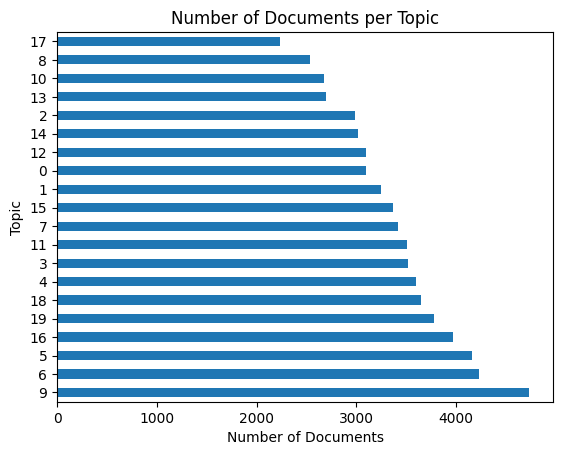

In [47]:
topics_counts.plot(kind="barh")
import matplotlib.pyplot as plt
plt.xlabel("Number of Documents")
plt.ylabel("Topic")
plt.title("Number of Documents per Topic")
plt.show()

We see the Topic 9 (that talks about word embeddings and representations) is the most prevalent across the ACL corpus

In [49]:
# get the documents associated with topic 9
topic9_documents = retained_acl_articles_with_topics[retained_acl_articles_with_topics["Topic"] == 9]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
topic9_documents.to_csv("Topic_9_documents.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The second most prevalent topic across the corpus is Topic 6 (which focuses on data annotations).

In [52]:
topic6_documents = retained_acl_articles_with_topics[retained_acl_articles_with_topics["Topic"] == 6]
topic6_documents.to_csv("Topic_6_documents.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
